In [ ]:
import os
import shutil
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/archive/edibility_dataset"
#Counting Pictures in Each Folder to adjust the class weights
for label in ["edible", "poisonous"]:
    folder_path = os.path.join(dataset_path, label)
    count = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    print(f"{label.capitalize()}: {count} images")


Edible: 6599 images
Poisonous: 3400 images


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Calculating Weights for each class
y = [0] * 6599 + [1] * 3400
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.7576147901197151), 1: np.float64(1.4704411764705883)}


In [ ]:
import tensorflow as tf
# Preprocessing the Images into 80 % Training and 20 % Validation
DATASET_PATH = "/content/drive/MyDrive/archive/edibility_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 9999 files belonging to 2 classes.
Using 8000 files for training.
Found 9999 files belonging to 2 classes.
Using 1999 files for validation.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
#Using the EfficentNetB0 as our Transfer Learning
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.save('/content/drive/My Drive/Models/trained_base_model.h5')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compiling the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 226s 69ms/step - accuracy: 0.7417 - loss: 0.5260 - val_accuracy: 0.8149 - val_loss: 0.3964
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8425 - loss: 0.3582 - val_accuracy: 0.8414 - val_loss: 0.3361
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8619 - loss: 0.3205 - val_accuracy: 0.8564 - val_loss: 0.3229
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8899 - loss: 0.2756 - val_accuracy: 0.8594 - val_loss: 0.3188
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9004 - loss: 0.2383 - val_accuracy: 0.8484 - val_loss: 0.3566


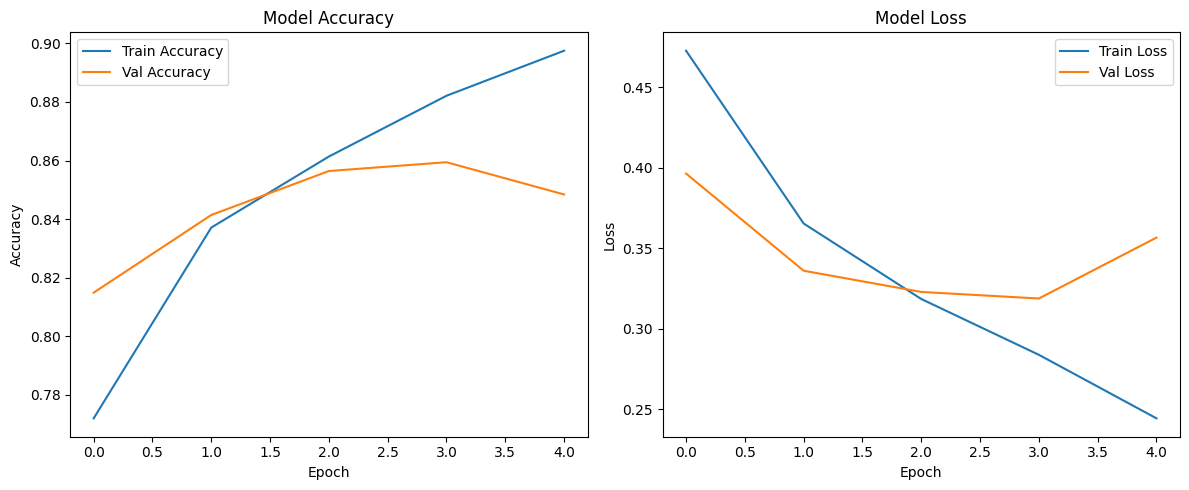

In [ ]:
import matplotlib.pyplot as plt
# Calulating Model Accuracy and Loss Graph for Visulization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━

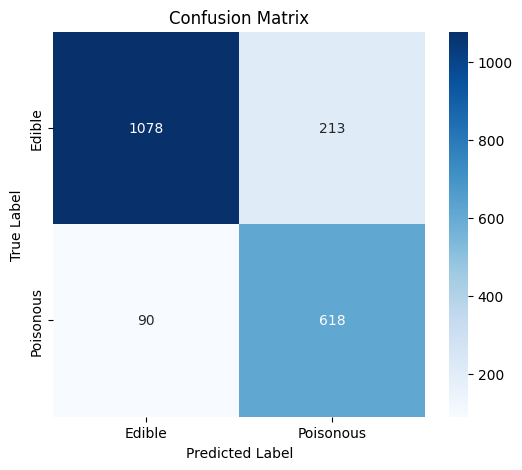

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Confussion Matrix Code + Accuracy + F1 Score
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
from tensorflow.keras.optimizers import Adam
#Fine Tuning the Last 20 year to our Dataset with Learning Rate of 1 x 10^-5
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.8252 - loss: 0.4157 - val_accuracy: 0.8429 - val_loss: 0.3820
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8561 - loss: 0.3257 - val_accuracy: 0.8499 - val_loss: 0.3564
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8721 - loss: 0.2909 - val_accuracy: 0.8589 - val_loss: 0.3385
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8957 - loss: 0.2480 - val_accuracy: 0.8659 - val_loss: 0.3242
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9062 - loss: 0.2234 - val_accuracy: 0.8684 - val_loss: 0.3178


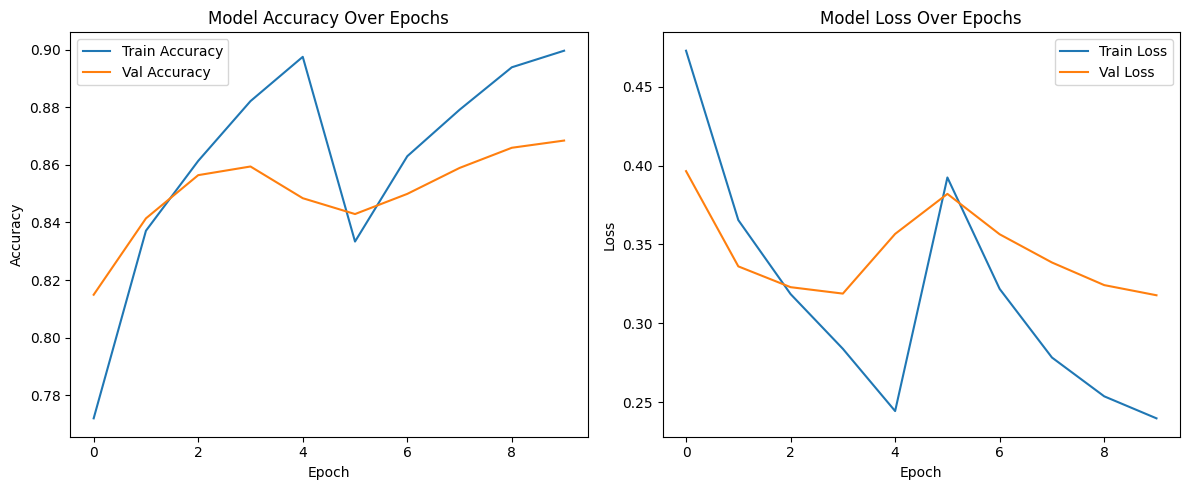

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━

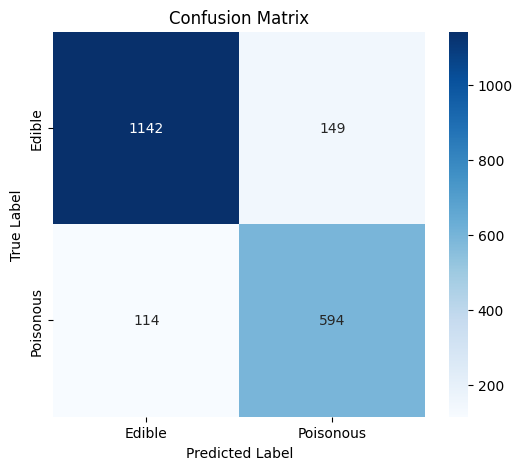

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int").flatten())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import os
import sys
import contextlib
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

# Redirect all output during TensorFlow imports
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras import layers, models
    from tensorflow.keras.applications import EfficientNetB0

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import logging

Accuracy: 0.8194097048524263
Precision: 0.7706708268330733
Recall: 0.6977401129943502
F1-score: 0.7323943661971831

Classification Report:
              precision    recall  f1-score   support

      Edible       0.84      0.89      0.86      1291
   Poisonous       0.77      0.70      0.73       708

    accuracy                           0.82      1999
   macro avg       0.81      0.79      0.80      1999
weighted avg       0.82      0.82      0.82      1999



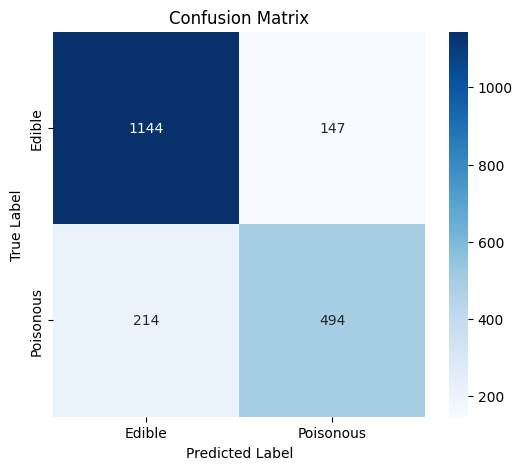

In [ ]:
#Quantizing the Model
def representative_dataset_gen():
    for images, _ in train_ds.take(100):
        yield [images.numpy()]

class CompleteSilence:
    def write(self, msg):
        pass
    def flush(self):
        pass

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(CompleteSilence()), contextlib.redirect_stderr(CompleteSilence()):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    quantized_tflite_model = converter.convert()

with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_true = []
y_pred = []

for images, labels in val_ds:
    for i in range(images.shape[0]):
        input_data = images[i].numpy()
        input_data = np.expand_dims(input_data, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_true.append(labels[i].numpy())
        y_pred.append((output_data > 0.5).astype("int").flatten()[0])

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Edible", "Poisonous"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Edible", "Poisonous"], yticklabels=["Edible", "Poisonous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()